## Electricity price prediction for NYC

In [1]:
import pandas as pd

import numpy as np
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pylab as plt
import datetime as dt
import time

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *

Using TensorFlow backend.


In [2]:
df_data = pd.read_csv('full_diff_data_2016_2017.csv', parse_dates=['time_stamp', 'time_stamp_local'])
df_data.set_index('time_stamp', inplace = True)

In [3]:
df_data.shape

(17520, 10)

In [4]:
df_data.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff'],
      dtype='object')

In [5]:
def shuffle_Xy(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [6]:
def train_test_ts_split(X, y, percentage=0.9):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_Xy(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [7]:
# Standardize inputs
# scaler_price = preprocessing.StandardScaler().fit(df_data.price.values.reshape(-1, 1))
# scaler_load = preprocessing.StandardScaler().fit(df_data.load.values.reshape(-1, 1))
# scaler_temp = preprocessing.StandardScaler().fit(df_data.temp.values.reshape(-1, 1))
# df_data.loc[:,'price_norm'] = scaler_price.transform(df_data.price.values.reshape(-1, 1))
# df_data.loc[:,'load_norm'] = scaler_load.transform(df_data.load.values.reshape(-1, 1))
# df_data.loc[:,'temp_norm'] = scaler_temp.transform(df_data.temp.values.reshape(-1, 1))

scaler_price = preprocessing.MinMaxScaler().fit(df_data.price_diff.values.reshape(-1, 1))
scaler_load = preprocessing.MinMaxScaler().fit(df_data.load_diff.values.reshape(-1, 1))
scaler_temp = preprocessing.MinMaxScaler().fit(df_data.temp_diff.values.reshape(-1, 1))
df_data.loc[:,'price_diff_norm'] = scaler_price.transform(df_data.price_diff.values.reshape(-1, 1))
df_data.loc[:,'load_diff_norm'] = scaler_load.transform(df_data.load_diff.values.reshape(-1, 1))
df_data.loc[:,'temp_diff_norm'] = scaler_temp.transform(df_data.temp_diff.values.reshape(-1, 1))

In [8]:
WINDOW = 24 * 7 - 1
EMB_SIZE = 3
STEP = 1
FORECAST = 0

X, Y = [], []
for i in range(0, df_data.shape[0], STEP): 
    try:
        price_byweek = df_data.price_diff_norm.values[i: i + WINDOW]
        load_byweek = df_data.load_diff_norm.values[i: i + WINDOW]
        temp_byweek = df_data.temp_diff_norm.values[i: i + WINDOW]

        x_i = np.column_stack((price_byweek, load_byweek, temp_byweek))
        # target doesn't have to be standardized
        y_i = df_data.price_diff.values[i + WINDOW + FORECAST]
    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)

In [9]:
X.shape, Y.shape

((17353, 167, 3), (17353,))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_ts_split(X, Y, percentage = 0.9)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15617, 167, 3), (1736, 167, 3), (15617,), (1736,))

In [11]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((15617, 167, 3), (1736, 167, 3), (15617,), (1736,))

In [12]:
bestmodel_name = 'best_weights_' + str(FORECAST) + '.hdf5'
checkpointer = ModelCheckpoint(filepath = bestmodel_name, 
                               verbose=1, save_best_only=True)

In [13]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=32,
                        filter_length=24,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Convolution1D(nb_filter=16,
                        filter_length=2,
                        border_mode='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling1D(pool_size=2, strides=None, padding='valid'))
model.add(Flatten())

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(optimizer='adam', 
              loss='mse')
history = model.fit(X_train, Y_train, 
          nb_epoch = 50, 
          batch_size = 128, 
          verbose=1, 
          validation_split=0.2,
          shuffle=True,
          callbacks=[checkpointer])

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(kernel_size=24, padding="same", filters=32, input_shape=(167, 3))`
  """
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", filters=16, kernel_size=2)`
  del sys.path[0]
/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py:874: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 12493 samples, validate on 3124 samples
Epoch 1/50
12493/12493 [==============================] - 19s 1ms/step - loss: 1024.2211 - val_loss: 1034.0927
Epoch 2/50
12493/12493 [==============================] - 18s 1ms/step - loss: 981.7352 - val_loss: 1033.8672
Epoch 3/50
12493/12493 [==============================] - 17s 1ms/step - loss: 924.2297 - val_loss: 1023.1873
Epoch 4/50
12493/12493 [==============================] - 17s 1ms/step - loss: 869.7299 - val_loss: 1134.3292
Epoch 5/50
12493/12493 [==============================] - 18s 1ms/step - loss: 834.4505 - val_loss: 1104.2053
Epoch 6/50
12493/12493 [==============================] - 17s 1ms/step - loss: 794.6416 - val_loss: 899.2984
Epoch 7/50
12493/12493 [==============================] - 18s 1ms/step - loss: 765.9333 - val_loss: 908.3984
Epoch 8/50
12493/12493 [==============================] - 18s 1ms/step - loss: 712.8637 - val_loss: 2712.6962
Epoch 9/50
12493/12493 [==============================] - 17s 1ms/step -

Epoch 36/50
12493/12493 [==============================] - 10s 835us/step - loss: 415.6396 - val_loss: 762.9242
Epoch 37/50
12493/12493 [==============================] - 10s 829us/step - loss: 417.1563 - val_loss: 1004.1008
Epoch 38/50
12493/12493 [==============================] - 10s 828us/step - loss: 411.9488 - val_loss: 789.1675
Epoch 39/50
12493/12493 [==============================] - 10s 826us/step - loss: 396.4913 - val_loss: 850.5755
Epoch 40/50
12493/12493 [==============================] - 10s 838us/step - loss: 351.2950 - val_loss: 756.3589
Epoch 41/50
12493/12493 [==============================] - 13s 1ms/step - loss: 354.7893 - val_loss: 742.5100
Epoch 42/50
12493/12493 [==============================] - 12s 936us/step - loss: 370.4506 - val_loss: 959.5299
Epoch 43/50
12493/12493 [==============================] - 12s 937us/step - loss: 352.4437 - val_loss: 803.6764
Epoch 44/50
12493/12493 [==============================] - 12s 945us/step - loss: 370.7432 - val_loss: 10

In [14]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 167, 32)           2336      
_________________________________________________________________
batch_normalization_1 (Batch (None, 167, 32)           128       
_________________________________________________________________
activation_1 (Activation)    (None, 167, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 83, 16)            1040      
_________________________________________________________________
batch_normalization_2 (Batch (None, 83, 16)            64        
_________________________________________________________________
activation_2 (Activation)    (None, 83, 16)            0         
__________

In [15]:
model.load_weights('best_weights_' + str(FORECAST) + '.hdf5')
pred = model.predict(np.array(X_test))

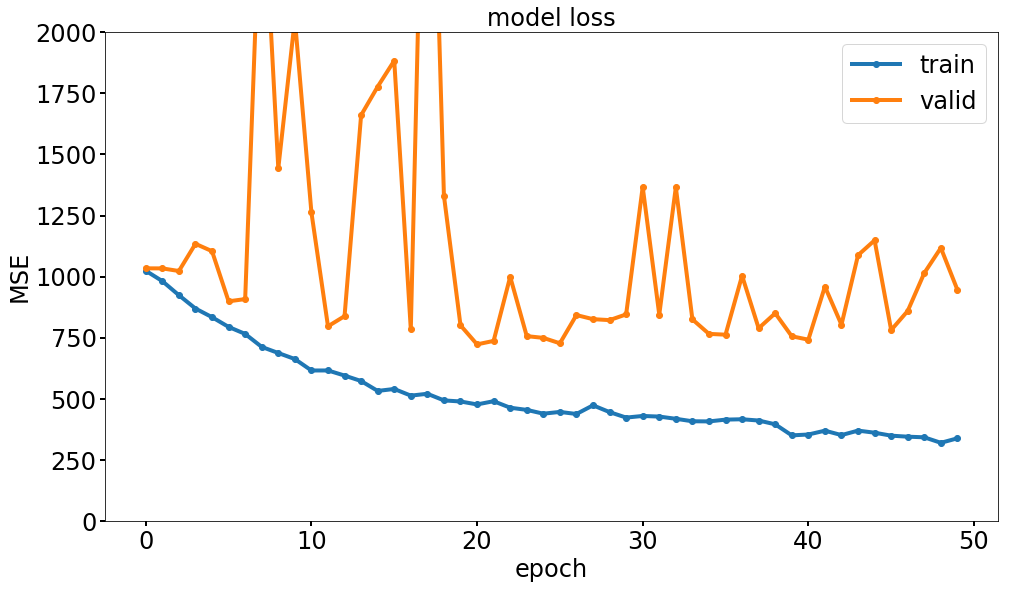

In [16]:
fig, ax = plt.subplots(figsize = (16, 9))
ax.plot(history.history['loss'], 'o-', linewidth = 4)
ax.plot(history.history['val_loss'], 'o-', linewidth = 4)
ax.set_title('model loss', fontsize = 24)
ax.set_ylabel('MSE', fontsize = 24)
ax.set_xlabel('epoch', fontsize = 24)
ax.set_ylim(0, 2000)
ax.legend(['train', 'valid'], loc='best', fontsize = 24)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
# new_tick_locs = range(0,20,2);
# new_tick_labels = range(0,20,2);
# ax.set_xticks(new_tick_locs);
# ax.set_xticklabels(new_tick_labels);

# ax.show()

In [17]:
df_data.columns

Index(['time_stamp_local', 'price', 'price_24hr_ago', 'price_diff', 'load',
       'load_24hr_ago', 'load_diff', 'temp', 'temp_24hr_ago', 'temp_diff',
       'price_diff_norm', 'load_diff_norm', 'temp_diff_norm'],
      dtype='object')

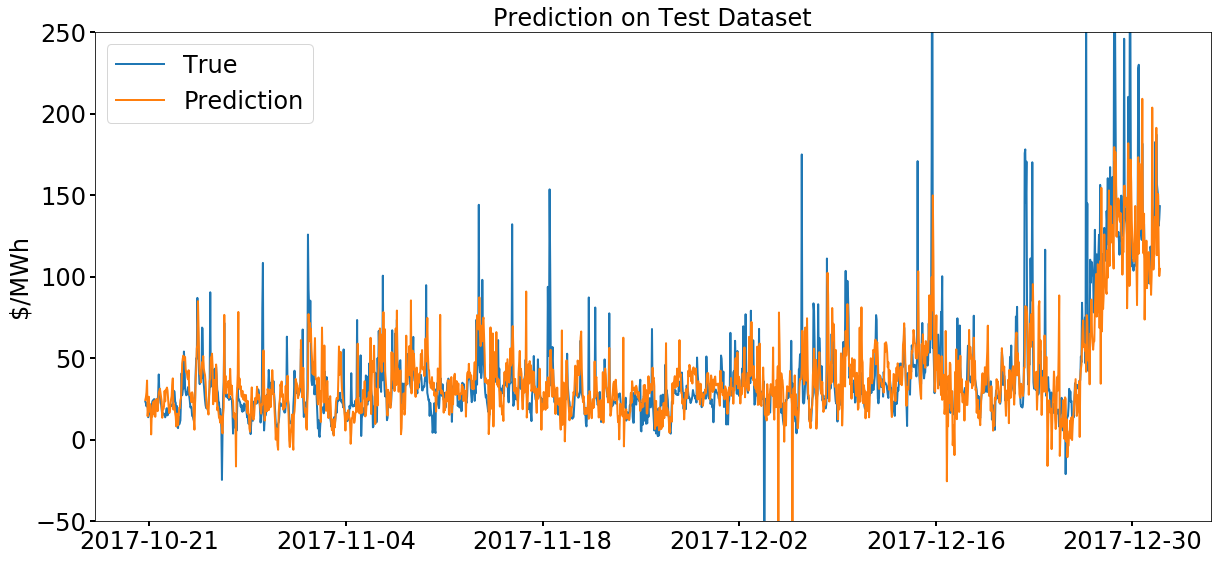

In [38]:
fig, ax = plt.subplots(figsize = (20, 9))
ax.plot(df_data.iloc[(167 + int((df_data.shape[0] - 167) * 0.9)):, 0], Y_test + df_data.price_24hr_ago.values[167 + int((df_data.shape[0] - 167) * 0.9):], linewidth = 2);
ax.plot(df_data.iloc[(167 + int((df_data.shape[0] - 167) * 0.9)):, 0], pred.ravel() + df_data.price_24hr_ago.values[167 + int((df_data.shape[0] - 167) * 0.9):], linewidth = 2)
# ax.plot(Y_test, linewidth = 2);
# ax.plot(pred.ravel(), linewidth = 2)
ax.set_title('Prediction on Test Dataset', fontsize = 24);
ax.set_ylabel('$/MWh', fontsize = 24);
# ax.set_xlim(pd.datetime(2017,10,20), pd.datetime(2018,1,1))
ax.set_ylim(-50, 250)
# # ax.set_xlim(0, Y_test.shape[0])
ax.legend(['True', 'Prediction'], loc='best', fontsize = 24)
ax.tick_params(axis='both',which='both',labelsize=24,\
        length=5,width=2,direction='out');
plt.savefig('cnn_pred.pdf', format = 'pdf')

In [19]:
# np.sqrt(metrics.mean_squared_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred)))
np.sqrt(metrics.mean_squared_error(Y_test.ravel(), pred.ravel()))

23.726193342794726

In [20]:
pred[-1]

array([ 6.40443325], dtype=float32)

In [21]:
# metrics.mean_absolute_error(scaler_price.inverse_transform(Y_test), scaler_price.inverse_transform(pred))
np.sqrt(metrics.mean_absolute_error(Y_test.ravel(), pred.ravel()))

3.707713427443835

In [22]:
df_hist = pd.DataFrame.from_dict(history.history)
df_hist.to_csv('history_' + str(FORECAST) + '.csv', index = False)